# Every Pandas Function You Can Use to Manipulate Time Series - Explained in N Minutes
## From date ranges to expanding window functions
![](images/pexels.jpg)
<figcaption style="text-align: center;">
    <strong>
        Photo by 
        <a href='https://www.pexels.com/@bentonphotocinema?utm_content=attributionCopyText&utm_medium=referral&utm_source=pexels'>Jordan Benton</a>
        on 
        <a href='https://www.pexels.com/photo/shallow-focus-of-clear-hourglass-1095601/?utm_content=attributionCopyText&utm_medium=referral&utm_source=pexels'>Pexels</a>
    </strong>
</figcaption>

### Setup

In [15]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import rcParams

rcParams["xtick.labelsize"] = 15
rcParams["ytick.labelsize"] = 15
rcParams["legend.fontsize"] = "small"

warnings.filterwarnings("ignore")

### Introduction to this Time Series project
TODO

## 1. Basic date and time functions in Pandas

### 1.1 Importing time series data

When using the `pd.read_csv` function to import time series, there are 2 arguments you should always use - `parse_dates` and `index_col`:

In [16]:
# Import Apple/Google stock prices
aapl_googl = pd.read_csv(
    "data/apple_google.csv", parse_dates=["Date"], index_col="Date"
)

In [17]:
aapl_googl.head()

,AAPL,GOOG
Date,,
2010-01-04,NaN,313.06
2010-01-05,NaN,311.68
2010-01-06,NaN,303.83
2010-01-07,NaN,296.75
2010-01-08,NaN,300.71


In [18]:
# Import S&P500 stock prices
sp500 = pd.read_csv("data/sp500.csv", parse_dates=["date"], index_col="date")

In [19]:
sp500.head()

,SP500
date,
2007-06-29,1503.35
2007-07-02,1519.43
2007-07-03,1524.87
2007-07-05,1525.40
2007-07-06,1530.44


`parse_dates` automatically converts date-like strings to DateTime objects and `index_col` sets the passed column to index. This operation is the basis for all time-series manipulation you will do with pandas.

When you don't have the luxury of knowing which column contains dates upon importing, you can do the date conversion afterwards using `pd.to_datetime` function:

In [20]:
# Import the data with unknown date column
sp500 = pd.read_csv("data/sp500.csv")

# Inspect the dtypes
sp500.dtypes

date      object
SP500    float64
dtype: object

Now, inspect the datetime format:

In [21]:
sp500.head()

,date,SP500
0,2007-06-29,1503.35
1,2007-07-02,1519.43
2,2007-07-03,1524.87
3,2007-07-05,1525.40
4,2007-07-06,1530.44


It is in the format "%Y-%m-%d" (full list of datetime format strings can be found [here](https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior)). Pass this to `pd.to_datetime`:

In [22]:
sp500["date"] = pd.to_datetime(sp500["date"], format="%Y-%m-%d", errors="coerce")

# Check if the conversion is successful
assert sp500["date"].dtype == "datetime64[ns]"

Passing a format string to `pd.to_datetime` significantly speeds up the conversion for large datasets. Set `errors` to "coerce" to mark invalid dates as `NaT` (not a date, i.e. - missing).

After conversion, set the DateTime column as index (a strict requirement for best time series analysis):

In [23]:
sp500.set_index("date", inplace=True)

### 1.2 Pandas TimeStamp

The basic date structure in Pandas is a timestamp:

In [24]:
stamp = pd.Timestamp("2020/12/26")  # You can pass any date-like string
stamp

Timestamp('2020-12-26 00:00:00')

You can make even more granular timestamps using the right format or better yet, using the `datetime` module:

In [25]:
from datetime import datetime

stamp = pd.Timestamp(
    datetime(year=2021, month=10, day=5, hour=13, minute=59, second=59)
)
stamp

Timestamp('2021-10-05 13:59:59')

A full timestamp has useful attributes such as these:

In [26]:
attributes = [
    ".year",
    ".month",
    ".quarter",
    ".day",
    ".hour",
    ".minute",
    ".second",
    ".weekday()",
    ".dayofweek",
    ".weekofyear",
    ".dayofyear",
]

pd.DataFrame(
    {
        "Attribute": attributes,
        "'2021-10-05 13:59:59'": [
            eval(f"stamp{attribute}") for attribute in attributes
        ],
    }
)

,Attribute,'2021-10-05 13:59:59'
0,.year,2021
1,.month,10
2,.quarter,4
3,.day,5
4,.hour,13
5,.minute,59
6,.second,59
7,.weekday(),1
8,.dayofweek,1
9,.weekofyear,40


### 1.3 Sequence of dates (timestamps)

A DateTime column/index in pandas is represented as a series of TimeStamp objects. `pd.date_range` returns a special DateTimeIndex object that is a collection of TimeStamps with a custom frequency over a given range:

In [27]:
index = pd.date_range(start="2010-10-10", end="2020-10-10", freq="M")
index

DatetimeIndex(['2010-10-31', '2010-11-30', '2010-12-31', '2011-01-31',
               '2011-02-28', '2011-03-31', '2011-04-30', '2011-05-31',
               '2011-06-30', '2011-07-31',
               ...
               '2019-12-31', '2020-01-31', '2020-02-29', '2020-03-31',
               '2020-04-30', '2020-05-31', '2020-06-30', '2020-07-31',
               '2020-08-31', '2020-09-30'],
              dtype='datetime64[ns]', length=120, freq='M')

After specifying the date range which is a 10 year period, we are telling pandas to generate TimeStamps on a monthly-basis with `freq='M'`:

In [28]:
index[0]

Timestamp('2010-10-31 00:00:00', freq='M')

Another way to create date ranges is passing the start date and telling how many periods you want and specifying the frequency:

In [29]:
pd.date_range(start="2020-01-01", periods=5, freq="Y")

DatetimeIndex(['2020-12-31', '2021-12-31', '2022-12-31', '2023-12-31',
               '2024-12-31'],
              dtype='datetime64[ns]', freq='A-DEC')

Since we set the frequency to years, `date_range` with 5 periods returns 5 years/timestamp objects. The [full list of frequency aliases](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timeseries-offset-aliases) you can pass to `freq` is large, so I will only mention the most important ones here:

In [30]:
aliases = ["B", "D", "W", "M", "BM", "MS", "Q", "H", "A, Y"]
values = [
    "Business days",
    "Calendar days",
    "Weekly",
    "Month end frequency",
    "Business month end frequency",
    "Month start frequency",
    "Quarterly",
    "Hourly",
    "Year end",
]

pd.DataFrame({"Frequency Alias": aliases, "Definition": values})

,Frequency Alias,Definition
0,B,Business days
1,D,Calendar days
2,W,Weekly
3,M,Month end frequency
4,BM,Business month end frequency
5,MS,Month start frequency
6,Q,Quarterly
7,H,Hourly
8,"A, Y",Year end


It is also possible to pass custom frequencies such as "1h30min", "5D", "2W", etc. Again, check out [this link](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timeseries-offset-aliases) for the full info.

### 1.4 Slicing

Slicing time series data can be very intuitive if the index is a DateTime. You can use something called partial slicing:

In [31]:
aapl_googl["2010":"2015"].sample(5)  # All rows within 2010 and 2015

,AAPL,GOOG
Date,,
2012-04-03,89.90,320.99
2013-12-27,80.01,558.64
2011-10-19,56.95,290.06
2010-12-16,45.89,295.56
2013-03-05,61.59,418.88


In [32]:
aapl_googl["2012-4":"2012-12"].sample(5)  # rows within April and December of 2012

,AAPL,GOOG
Date,,
2012-06-20,83.68,288.47
2012-08-24,94.75,338.98
2012-05-08,81.17,306.09
2012-10-18,90.38,347.15
2012-07-13,86.42,287.97


You can even go down to hours, minutes or seconds levels if the DateTime is granular enough. 

Note that pandas slices dates in closed intervals. For example, using "2010": "2013" returns rows for all 4 years - it does not exclude the end of the period like integer slicing.

This date slicing logic applies to other operations like choosing a specific column after the slice:

In [33]:
aapl_googl.loc["2012-10-10":"2012-12-10", "GOOG"].head()

Date
2012-10-10    371.91
2012-10-11    375.36
2012-10-12    372.00
2012-10-15    370.12
2012-10-16    371.98
Name: GOOG, dtype: float64

## 2. Missing data imputation or interpolation

Missing data is ubiquitous no matter the type of the dataset. This section is all about imputing missing data in time series. You may also hear it called 'interpolation' of missing data in time series lingo.

Besides the basic mean, median and mode imputation, there are specific techniques that only apply to time series nulls. These are:

1. Forward filling
2. Backward filling
3. Intermediate imputations with `pd.interpolate`

We will also discuss model-based imputation techniques such as KNN imputing. Moreover, we will see visual methods of comparing the efficiency of imputation techniques and choose the one that best fits the underlying distribution.

### 2.1 Mean, median and mode imputation

Let's start with the basics. We will randomly select data points in Apple/Google stock dataset and convert them to NaN so we can compare the techniques.

In [34]:
# Choose 200 random
random_indices = np.random.choice([_ for _ in range(len(aapl_googl))], size=200)

# Mark the indices as missing
clone = aapl_googl.copy(deep=True).drop("AAPL", axis=1)
clone.iloc[random_indices, 0] = np.nan

We will also create a function that plots the original distribution before and after an imputation(s) is performed:

In [35]:
def compare_dists(original_dist, imputed_dists: dict):
    """
    Plot original_dist and imputed_dists on top of each other
    to see the difference in distributions
    """
    fig, ax = plt.subplots(figsize=(12, 7), dpi=140)
    # Plot the original
    sns.kdeplot(
        original_dist, linewidth=5, ax=ax, color="black", label="Original dist."
    )
    for key, value in imputed_dists.items():
        sns.kdeplot(value, linewidth=3, label=key, ax=ax)

    plt.legend()
    plt.show();

Now, let's finally do the imputations and assign them back into the DataFrame for comparison. We will use the `SimpleImputer` class from `sklearn`:

In [37]:
from sklearn.impute import SimpleImputer

for method in ["mean", "median", "most_frequent"]:
    clone[method] = SimpleImputer(strategy=method).fit_transform(
        clone["GOOG"].values.reshape(-1, 1)
    )

Let's plot the original GOOG distribution against the 3 imputed features we just created:

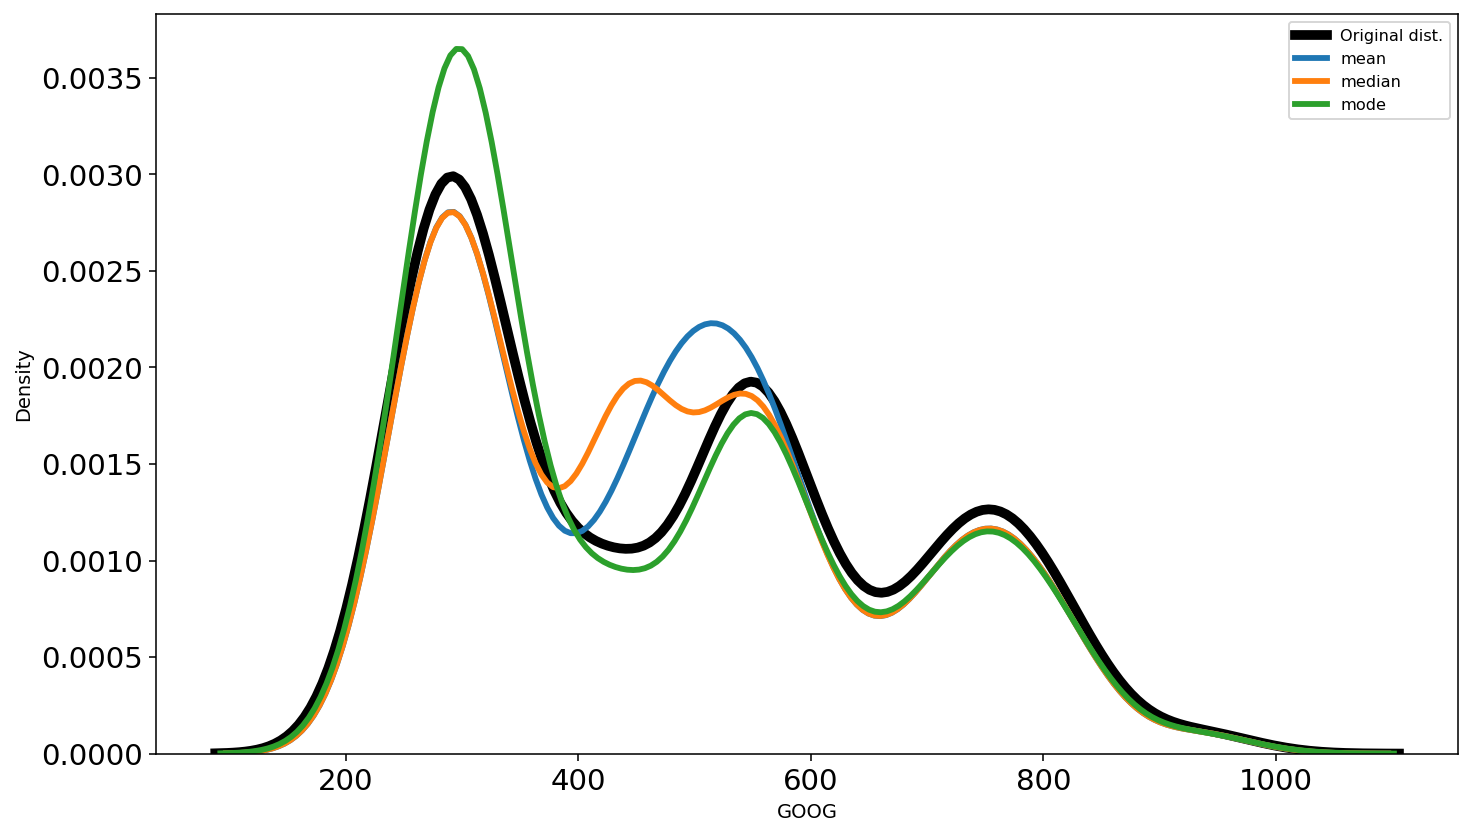

In [39]:
compare_dists(
    clone["GOOG"],
    {"mean": clone["mean"], "median": clone["median"], "mode": clone["most_frequent"]},
)

As you can see, mode imputation (green) most closely matches the blue line. Let's see if we can do any better: